In [2]:
# Set seeds for repeatability.
from numpy.random import seed
seed(1)

# Import data processing modules.
import pandas as pd
import numpy as np

import wandb
from wandb.keras import WandbCallback

# Import Omphalos modules.
import generate_inputs as gi
import file_methods as fm
import my_metrics as mm
import omphalos_plotter as op
import attributes as attr
import labels as lbls

# Import data visualisation modules.
import seaborn as sns
import matplotlib.pyplot as plt

# Import sklearn. 
import sklearn.preprocessing as skp
import sklearn.gaussian_process as gp
import sklearn.gaussian_process.kernels as kernels

In [3]:
train_set = fm.unpickle('rifle_pp_train.pickle')
test_set = fm.unpickle('rifle_pp_test.pickle')

attributes_df = attr.initial_conditions(train_set, primary_species=True, mineral_vols=True)
attributes_df.drop(columns=['X', 'Y', 'Z', 'C5H7O2NSO4'], inplace=True)
labels_df = lbls.secondary_precip(train_set)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:6390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


# SK-learn pipeline

In [4]:
x = attributes_df.loc[:, ['CO2(aq)', 'Ca++', 'Calcite' ,'SO4--', 'Formaldehyde']].xs(1, level=1)
y = (labels_df.xs(5, level=1)['Calcite'] + labels_df.xs(5, level=1)['Calcite44']).drop(columns=['File Num'])

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['Calcite', 'Formaldehyde'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, Normalizer, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')

numeric_transformer = Pipeline(steps=[('scaler', scaler)])
#numeric_transformer = Pipeline(steps=[('scaler', scaler), ('normalizer', Normalizer())])

In [ ]:
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer, Normalizer, quantile_transform
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel

#kernel = (Matern(length_scale=2, nu=2.5) + DotProduct()) * RBF(length_scale=1) + WhiteKernel()
#kernel = (Matern(length_scale=2, nu=2.5) + (DotProduct())) * RBF(length_scale=1) + WhiteKernel()
#kernel = (Matern(length_scale=0.00001, nu=2.5) + WhiteKernel())
kernel = RBF(length_scale=[0.001], length_scale_bounds=(1e-10, 1))

#regressor = TransformedTargetRegressor(regressor=GaussianProcessRegressor(kernel, n_restarts_optimizer=1, alpha=1e-3), transformer=QuantileTransformer(output_distribution='normal'))
regressor = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, alpha=1e-7, random_state=1)

rf = Pipeline(steps=[('regressor', regressor)])

In [ ]:
rf.fit(x_train, y_train)

# Plot cross-section of model.

In [12]:
samples = 5000
x_pred = np.ones((samples, 5))
x_pred[:,0] = x.to_numpy()[:,0].mean()
x_pred[:,2] = x.to_numpy()[:,2].mean()
x_pred[:,3] = x.to_numpy()[:,3].mean()
#x_pred[:,1] = x.to_numpy()[:,1].mean()
x_pred[:,1] = np.ones(samples) * 0.02
x_pred[:,4] = np.linspace(0.00, 0.056, samples)
y_pred, sigmas = rf.predict(x_pred, return_std=True)

/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [40]:
%%time
# Now in 2D!
samples = 5000
sulfate_samples = 15

y_pred = np.empty((samples, sulfate_samples))

for i, sulfate in enumerate(np.linspace(0, 0.56, sulfate_samples)):
    x_pred = np.ones((samples, 5))
    x_pred[:,0] = x.to_numpy()[:,0].mean()
    x_pred[:,2] = x.to_numpy()[:,2].mean()
    x_pred[:,3] = x.to_numpy()[:,3].mean()
    #x_pred[:,1] = x.to_numpy()[:,1].mean()
    x_pred[:,1] = np.ones(samples) * sulfate
    x_pred[:,4] = np.linspace(0.00, 0.056, samples)
    y_pred[:, i], sigmas = rf.predict(x_pred, return_std=True)

/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.


CPU times: user 5min 27s, sys: 13.9 s, total: 5min 41s
Wall time: 1min 39s


In [48]:
np.shape(y_pred)

(5000, 15)

In [64]:
X, Y = np.meshgrid(x_pred[:,4], np.linspace(0, 0.56, sulfate_samples))

print(np.shape(x_pred[:,4]))
print(np.shape(np.linspace(0, 0.56, sulfate_samples)))
print(np.shape(y_pred))
#Y=np.linspace(0, 0.56, sulfate_samples)

(5000,)
(15,)
(5000, 15)


Text(0, 0.5, '[Ca++]')

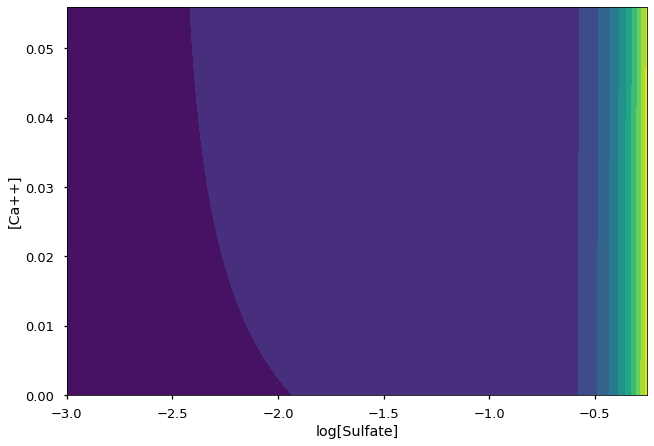

In [90]:
plt.contourf(np.log10(np.linspace(0.001, 0.56, sulfate_samples)), x_pred[:,4], y_pred, levels=10)
plt.xlabel('log[Sulfate]')
plt.ylabel('[Ca++]')

In [ ]:
plt.style.use('seaborn-talk')
for i, x_label, x_data, sample_bound, crunch_point in zip((1, 2, 3, 4, 5), ['[CO$_{2(aq)}$] (M)', '[Ca$^{2+}$] (M)', '[Formaldehyde] (M)', 'Calcite (vol. frac.)', '[SO$_4^{2-}$] (M)'],
    [x_train['CO2(aq)'], x_train['Ca++'], x_train['Formaldehyde'], x_train['Calcite'], x_train['SO4--']],
    [[0.0009, 0.0029], [0,0], [0.04, 0.07], [0.08, 0.10], [0.021, 0.031]],
    [2.00e-3, 1.02e-2, 0.55e-01, 0.313, 26.79609e-03]):
    #g = sns.jointplot(x=x_data, y=y_train, kind="scatter", color=[0.3663776351765568, 0.6057935659905949, 0.6135760192192385], marker='o', s=15, height=10)
    g = sns.jointplot(x=x_data, y=y_train, kind="scatter", hue=x_train['Ca++'], marker='o', s=15, height=10)
    g.ax_joint.set_xlabel(x_label)
    g.ax_joint.set_ylabel('Change in total Calcite (vol. frac.)')
    x_mean = x_data.mean()
    g.ax_joint.scatter(crunch_point, 0.0001048420800000005, marker='*', color='#b2353a', label='Site 1086', zorder=2)
    g.ax_joint.legend()
    #g.ax_joint.set_xlim(0, 0.02)
    #g.ax_joint.set_ylim(-0.001, 0.002)
    #g.ax_joint.plot(np.ones(100) * x_mean, np.linspace(-0.0010, 0.0015, 100), '--', color='#536267')
    #g.ax_joint.plot(np.ones(100) * sample_bound[0], np.linspace(-0.0010, 0.0015, 100), '-', color='#536267')
    #g.ax_joint.plot(np.ones(100) * sample_bound[1], np.linspace(-0.0010, 0.0015, 100), '-', color='#536267')
    g.savefig('fig{}.svg'.format(i))



/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

In [23]:
x_train['Formaldehyde'].mean()
#x_train[ (x_train['SO4--'] >= 0.0255) & (x_train['SO4--'] <= 0.0275)]

0.05453229669575276

In [90]:
test = x_train[(x_train['Formaldehyde'] >= 0.04) & (x_train['Formaldehyde'] <= 0.07) & (x_train['CO2(aq)'] >= 0.0009) & (x_train['CO2(aq)'] <= 0.0029) 
               & (x_train['Calcite'] >= 0.08) & (x_train['Calcite'] <= 0.10) & (x_train['SO4--'] >= 0.021) & (x_train['SO4--'] <= 0.031)]
test

,CO2(aq),Ca++,Calcite,Calcite44,SO4--,Formaldehyde
File Num,,,,,,
1691,0.002540,0.009753,0.093882,0.001990,0.024818,0.053007
5701,0.001974,0.010541,0.087794,0.001861,0.021663,0.051739
1769,0.001907,0.003147,0.086484,0.001833,0.026991,0.069586
29,0.002306,0.031448,0.090947,0.001928,0.026218,0.044569
5714,0.002546,0.003549,0.090387,0.001916,0.026632,0.061366
8470,0.002736,0.002945,0.080586,0.001708,0.021255,0.040924
2973,0.002308,0.015683,0.081228,0.001722,0.027690,0.041198
8502,0.002738,0.003398,0.087894,0.001863,0.028605,0.053709
9903,0.002656,0.028179,0.085981,0.001823,0.023570,0.055203


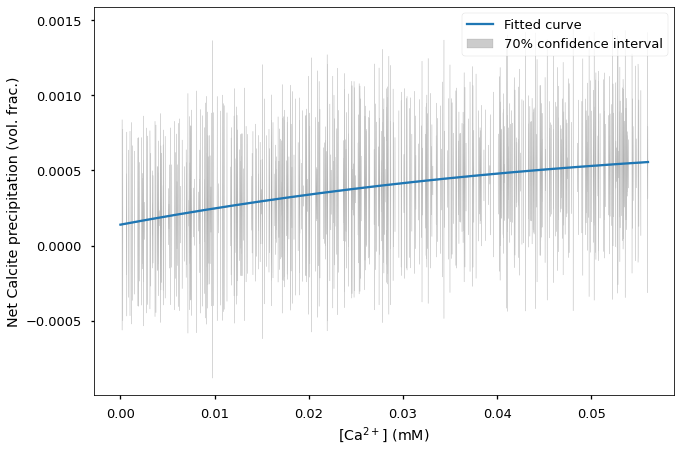

In [13]:
#f = plt.errorbar(x_pred[:,1], y_pred, yerr=sigmas, capsize=0, ecolor='#01153e10', label='Fitted curve & 70% confidence interval')
species_index = 4

plt.style.use('seaborn-talk')
f, ax = plt.subplots(1,1)
ax.plot(x_pred[:, species_index], y_pred, label='Fitted curve')
ax.fill_between(x_pred[:, species_index], y_pred - sigmas, y_pred + sigmas, alpha=0.2, color='k', label='70% confidence interval')
#ax.scatter(test['Ca++'].to_numpy(), y_train[test.index], marker="+", color='#980002', label='Modelled Net Precipitation')
ax.set_xlabel('[Ca$^{2+}$] (mM)')
ax.set_ylabel('Net Calcite precipitation (vol. frac.)')
plt.legend()
plt.savefig('fit.png', dpi=300, bbox_inches='tight')
#ax.set_xlim(0.000, 0.04)
#ax.set_ylim(-0.001, 0.001)
#plt.savefig('fit_zoom.png', dpi=300, bbox_inches='tight')


In [27]:
print(rf.score(x_train, y_train))
print(rf.score(x_test, y_test))

0.9420212842747303
0.9314573094069395


In [92]:
rf['regressor'].__dict__

{'kernel': RBF(length_scale=0.001),
 'alpha': 1e-07,
 'optimizer': 'fmin_l_bfgs_b',
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'copy_X_train': True,
 'random_state': 1,
 'kernel_': RBF(length_scale=0.653),
 '_rng': RandomState(MT19937) at 0x145B8A440,
 'n_features_in_': 6,
 '_y_train_mean': array([0.]),
 '_y_train_std': 1,
 'X_train_': array([[1.44879180e-04, 7.69962694e-03, 4.64735580e-02, 9.85245739e-04,
         4.30820449e-02, 1.70997763e-04],
        [1.92896258e-03, 5.08731905e-03, 1.49288024e-01, 3.16492638e-03,
         6.25959078e-03, 4.48745582e-02],
        [1.79174351e-05, 2.12888498e-02, 3.20261020e-02, 6.78957709e-04,
         7.65274785e-02, 7.69750695e-03],
        ...,
        [2.92206418e-03, 2.95751472e-03, 1.16786914e-01, 2.47589844e-03,
         2.02035561e-03, 1.21944219e-01],
        [5.05671163e-03, 1.77476278e-02, 4.57139321e-02, 9.69141566e-04,
         2.08641552e-03, 1.61858876e-01],
        [1.66297598e-03, 6.32878611e-03, 4.00774907e-02, 8.4964824

In [28]:
y_pred = rf.predict(x_test)
percent = (100 * ((y_pred - y_test) / y_test))
percent.describe()

count    2.000000e+03
mean    -2.687128e+03
std      1.232016e+05
min     -5.509030e+06
25%     -2.157800e+01
50%     -7.821809e+00
75%      1.212061e+01
max      6.355851e+04
dtype: float64

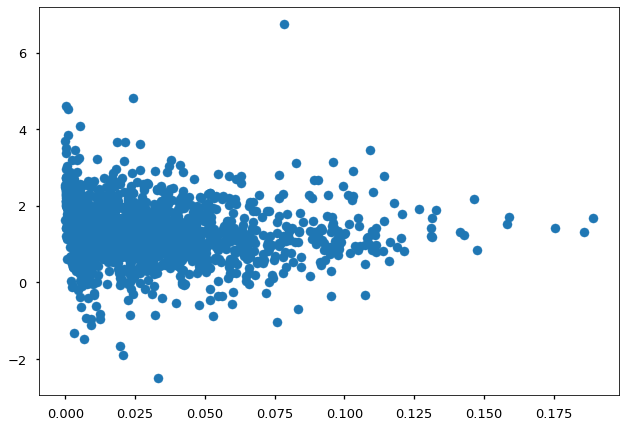

In [35]:
plt.scatter(x_test['SO4--'].to_numpy(), np.log10(abs(percent)))

(-1000.0, 1000.0)

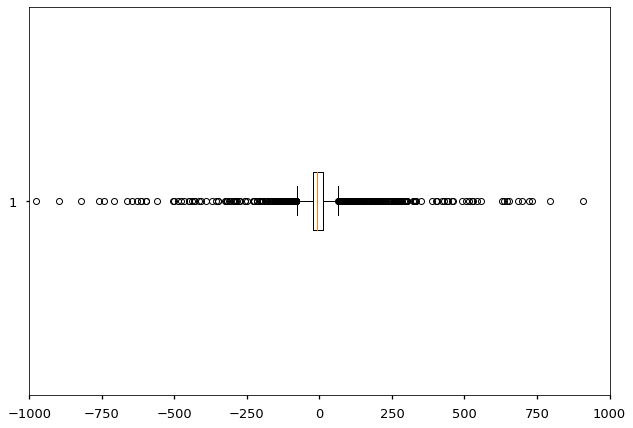

In [94]:
f = plt.boxplot(percent, vert=False)
plt.xlim(-1000,1000)

In [221]:
# from sklearn.preprocessing import power_transform

v = rf[:1].fit_transform(x_train)
w = np.array(y_train)
u = quantile_transform(w.reshape(-1,1), output_distribution='normal')